In [154]:
import random

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import trange
import torchvision.transforms
from torch import Tensor
from sklearn.manifold import TSNE
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import MNIST, FashionMNIST

In [167]:
train_val_data = MNIST(
    "./data",
    download=True,
    transform=torchvision.transforms.Compose(
        [
            # torchvision.transforms.Pad(padding=2),
            torchvision.transforms.ToTensor(),
        ]
    ),
)
test_data = MNIST(
    "./data",
    download=True,
    train=False,
    transform=torchvision.transforms.Compose(
        [
            # torchvision.transforms.Pad(padding=2),
            torchvision.transforms.ToTensor(),
        ]
    ),
)
val_size = 10000
train_size = len(train_val_data) - val_size
train_dataset, val_dataset = random_split(train_val_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [164]:
sample = train_dataset[0][0]
sample_batch = torch.vstack([sample] * 10).unsqueeze(1)
# sns.histplot(sample[sample!=0].flatten(),bins=500)
sample_batch.shape

torch.Size([10, 1, 28, 28])

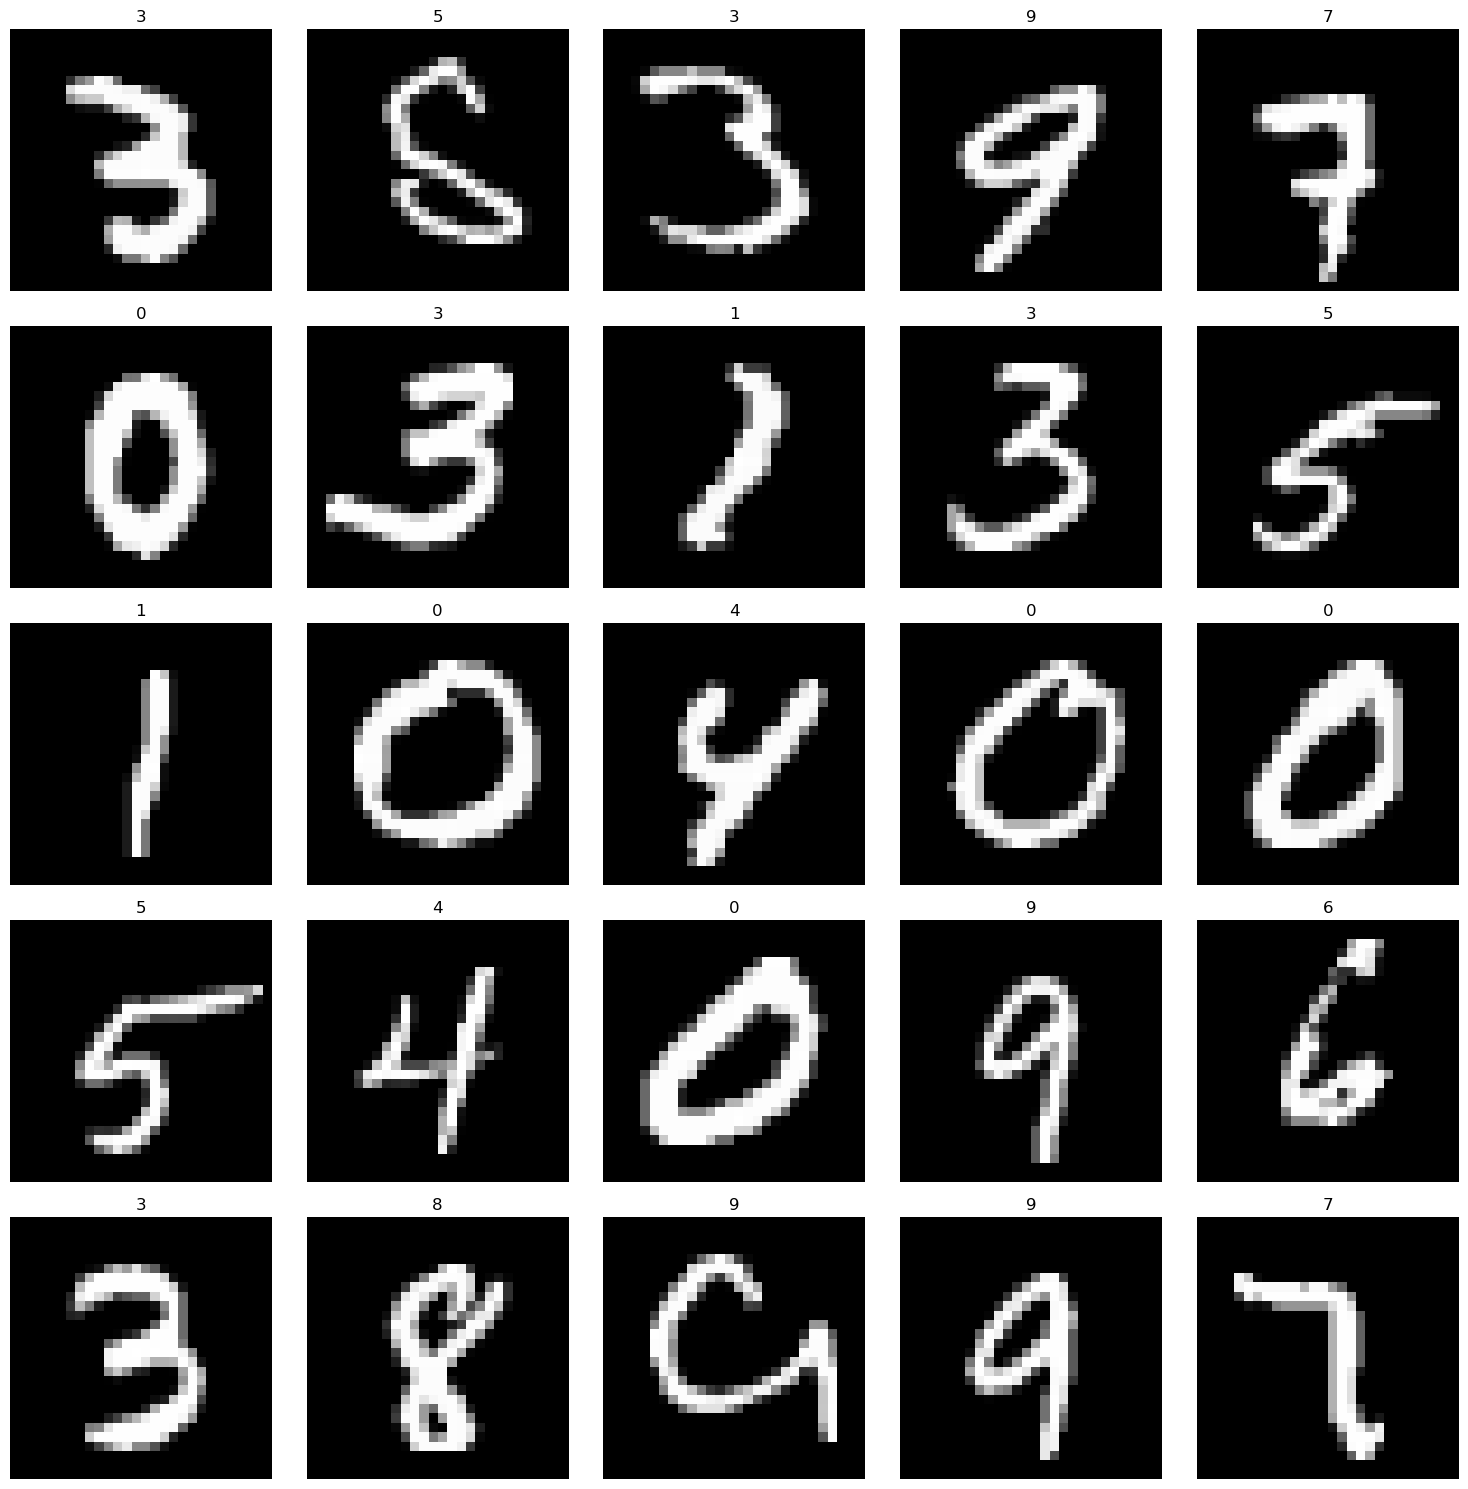

In [160]:
def display_random_image_grid(image_label_pairs):
    """
    Displays a grid of 25 randomly selected images with titles being their respective labels.
    If less than 25 images are provided, it displays all of them.

    :param image_label_pairs: A list of (image, label) tuples.
    """
    # Randomly sample 25 elements from the list (or all if the list is shorter).
    num_samples = min(25, len(image_label_pairs))
    sampled_image_label_pairs = random.sample(image_label_pairs, num_samples)

    # Set the dimensions of the grid.
    num_columns = 5
    num_rows = num_samples // num_columns + int(num_samples % num_columns > 0)

    # Create a figure with subplots in a grid.
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for ax, (image, label) in zip(axes, sampled_image_label_pairs):
        ax.imshow(image.squeeze(0), cmap="gray")  # Display the image.
        ax.set_title(label)  # Set the title to be the label.
        ax.axis("off")  # Hide the axes ticks.

    # Hide any unused subplot areas.
    for ax in axes[num_samples:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


display_random_image_grid(list(train_dataset))

# Let us gradually build more complex networks.


In [170]:
def viz_test_embeddings(model, latent_idx=-1):
    model.eval()
    print("Getting embeddings...")
    embs = []
    labels = []
    for d, label in test_data:
        latent = model(d.unsqueeze(0))[latent_idx]
        embs.append(latent.detach().numpy().flatten())
        labels.append(label)
    embs = np.array(embs)
    labels = np.array(labels)
    # # Project embeddings in 2d
    # print("Performing t-SNE")
    # tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
    # tsne_results = tsne.fit_transform(embs)
    # print("Plotting...")
    tsne_results = embs
    # Visualize
    num_classes = len(np.unique(labels))
    # Define a colormap with discrete colors
    cmap = plt.colormaps["tab10"]

    # Create the scatter plot
    scatter = plt.scatter(
        tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.5
    )

    # Create a colorbar with discrete boundaries
    bounds = np.arange(-0.5, num_classes + 0.5, 1)  # boundaries for each label
    norm = plt.Normalize(vmin=min(labels) - 0.5, vmax=max(labels) + 0.5)
    cb = plt.colorbar(
        scatter,
        spacing="proportional",
        ticks=np.arange(min(labels), max(labels) + 1),
        boundaries=bounds,
        format="%1i",
        norm=norm,
    )
    cb.set_label("Label")

    # Set plot title and labels
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

## Fully connected autoencoders


In [ ]:
class AE1(L.LightningModule):
    def __init__(self, z_dim=10) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim),
        )
        # We can use sigmoid as the input is normalised bw 0/1, and sigmoid enforces that
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28)),
        )

    def loss(self, x, decoded):
        return F.mse_loss(x.flatten(1), decoded.flatten(1))

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

    def training_step(self, batch):
        x, _ = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, _ = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        self.log("Loss/val", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


model = AE1()
# model(sample_batch)[0].shape
logger = TensorBoardLogger("tb_logs", name="autoencoder")
trainer = L.Trainer(max_epochs=10, log_every_n_steps=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Getting embeddings...
Performing t-SNE
Plotting...


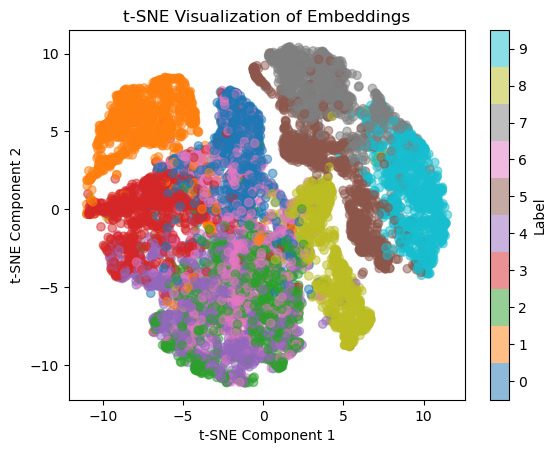

In [124]:
viz_test_embeddings(model)

In [168]:
class VAE1(L.LightningModule):
    def __init__(self, z_dim=2) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim),
        )
        self.encode_mu = nn.Sequential(nn.ReLU(), nn.Linear(z_dim, z_dim))

        self.encode_logvar = nn.Sequential(nn.ReLU(), nn.Linear(z_dim, z_dim))
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28)),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(
            0.5 * logvar
        )  # logvar is log(sigma^2), so this makes it just sigma
        eps = torch.randn_like(std)
        return mu + eps * std

    def loss(self, x, mu, logvar, decoded):
        MSE = F.mse_loss(x.flatten(1), decoded.flatten(1))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return KLD + MSE

    def forward(self, x):
        enc_out = self.encoder(x)
        mu, logvar = self.encode_mu(enc_out), self.encode_logvar(enc_out)
        latent = self.reparameterize(mu, logvar)
        out = self.decoder(latent)
        return out, mu, logvar, latent

    def training_step(self, batch):
        x, _ = batch
        out, mu, logvar, _ = self(x)
        loss = self.loss(x, mu, logvar, out)
        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, _ = batch
        out, mu, logvar, _ = self(x)
        loss = self.loss(x, mu, logvar, out)
        self.log("Loss/val", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


model = VAE1()
# model(sample_batch)[0].shape
logger = TensorBoardLogger("tb_logs", name="autoencoder")
trainer = L.Trainer(max_epochs=10, log_every_n_steps=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/rohan/Desktop/Python_files/things_from_scratch/notebooks/lightning_logs

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 533 K 
1 | encode_mu     | Sequential | 6     
2 | encode_logvar | Sequential | 6     
3 | decoder       | Sequential | 534 K 
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.273     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/rohan/miniconda3/envs/advent_of_code/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/rohan/miniconda3/envs/advent_of_code/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Getting embeddings...


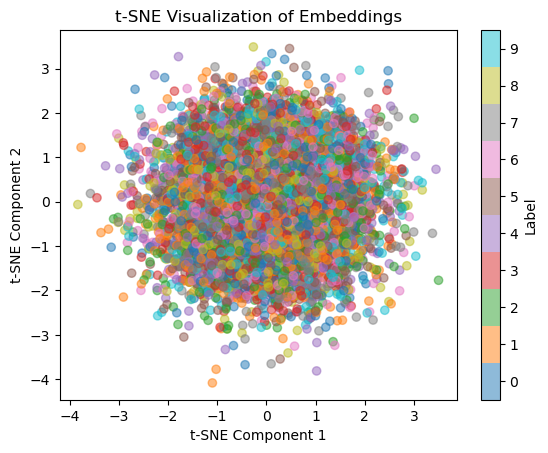

In [171]:
viz_test_embeddings(model)

# Vanilla Autoencoder

- Good compression = good learning ( see [Kolmogorov complexity](https://en.wikipedia.org/wiki/Kolmogorov_complexity))
- Can do PCA on latent space, and see trends/dominant factors in the data
- https://www.youtube.com/watch?v=FslFZx08beM


In [58]:
z_dim = 5
encoder = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
    nn.MaxPool2d(1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.MaxPool2d(1),
    nn.ReLU(),
    # nn.Flatten(),
    # nn.Linear(800, z_dim),
)
encoder(sample_batch).shape

torch.Size([10, 64, 7, 7])

In [135]:
def get_pre_post_flatten_size(model, input_shape):
    with torch.no_grad():
        input = torch.zeros(*input_shape)
        output = model(input)
        # remove output batch dimension(is 1)
        return output.squeeze(0).size(), output.numel()

In [233]:
class AE(L.LightningModule):
    def __init__(self, z_dim=10) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.z_dim = z_dim

        self.c1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.p1 = nn.MaxPool2d(2, return_indices=True)
        self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.p2 = nn.MaxPool2d(2, return_indices=True)
        self.pre_flatten_size, self.post_flatten_size = (64, 2, 2), 256
        self.fc1 = nn.Linear(self.post_flatten_size, z_dim)

        self.fc2 = nn.Linear(z_dim, self.post_flatten_size)
        self.up1 = nn.MaxUnpool2d(2)
        self.uc1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.up2 = nn.MaxUnpool2d(2)
        self.uc2 = nn.ConvTranspose2d(
            32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
        )

    def loss(self, x, decoded):
        return F.mse_loss(x.flatten(1), decoded.flatten(1))
        # loss = F.binary_cross_entropy(x.flatten(1), decoded.flatten(1))

    def forward(self, x):
        x = self.c1(x)
        x, idx1 = self.p1(x)
        # print(f"After p1: {x.shape}, {torch.isnan(x).any()}")
        # print(x.size())
        x = F.relu(x)
        x = self.c2(x)
        x, idx2 = self.p2(x)
        # print(f"After p2: {x.shape}, {torch.isnan(x).any()}")
        # print(x.size())
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        # print(f"Pre FC: {x.shape}, {torch.isnan(x).any()}")
        latent = self.fc1(x)
        # post_flatten_size = x.size(1)
        out = self.fc2(latent)
        out = out.view(out.size(0), *self.pre_flatten_size)
        out = F.relu(out)
        # print(out.size())
        out = self.up1(out, idx2)
        out = self.uc1(out)
        out = F.relu(out)
        # print(out.size())
        out = self.up2(out, idx1)
        # print(out.size())
        out = self.uc2(out)
        out = F.sigmoid(out)

        return out, latent

    def training_step(self, batch):
        x, _label = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, _label = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        self.log("Loss/val", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, _label = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [234]:
model = AE()
model(sample_batch)[0].size()

torch.Size([10, 1, 28, 28])

In [ ]:
model = AE()


# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)


# model.apply(weights_init)
logger = TensorBoardLogger("tb_logs", name="autoencoder")
trainer = L.Trainer(max_epochs=10, log_every_n_steps=10, accelerator="cpu")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [198]:
embs = []
labels = []
for d, label in test_data:
    _, latent = model(d.unsqueeze(0))
    embs.append(latent.detach().numpy().flatten())
    labels.append(label)
embs = np.array(embs)
labels = np.array(labels)

In [199]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 0.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.617400
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.209785
[t-SNE] KL divergence after 300 iterations: 3.134444


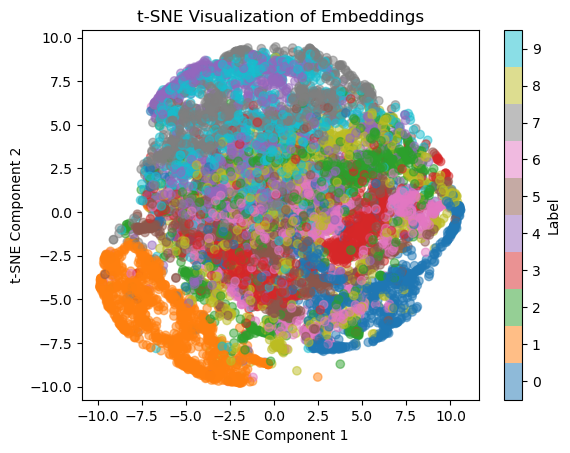

In [201]:
num_classes = len(np.unique(labels))
# Define a colormap with discrete colors
cmap = plt.colormaps["tab10"]

# Create the scatter plot
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.5
)

# Create a colorbar with discrete boundaries
bounds = np.arange(-0.5, len(np.unique(labels)) + 0.5, 1)  # boundaries for each label
norm = plt.Normalize(vmin=min(labels) - 0.5, vmax=max(labels) + 0.5)
cb = plt.colorbar(
    scatter,
    spacing="proportional",
    ticks=np.arange(min(labels), max(labels) + 1),
    boundaries=bounds,
    format="%1i",
    norm=norm,
)
cb.set_label("Label")

# Set plot title and labels
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Variational autoencoder

- The latent space is made to follow a distribution, and that distribution can then be sampled for generative purposes


In [55]:
class VAE(L.LightningModule):
    def __init__(self, z_dim=10) -> None:
        super().__init__()
        self.z_dim = z_dim
        self.c1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.p1 = nn.MaxPool2d(1, return_indices=True)
        self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.p2 = nn.MaxPool2d(1, return_indices=True)
        # self.c3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        # self.pre_flatten_size, self.post_flatten_size = (64, 2, 2), 256
        self.pre_flatten_size, self.post_flatten_size = (64, 7, 7), 3136
        self.fc1 = nn.Linear(self.post_flatten_size, z_dim)

        self.fc2 = nn.Linear(z_dim, self.post_flatten_size)
        self.up1 = nn.MaxUnpool2d(1)
        self.uc1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.up2 = nn.MaxUnpool2d(1)
        self.uc2 = nn.ConvTranspose2d(
            32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.encode_mu = nn.Sequential(
            nn.ReLU(), nn.Linear(z_dim, z_dim), nn.ReLU(), nn.Linear(z_dim, z_dim)
        )

        self.encode_std = nn.Sequential(
            nn.ReLU(), nn.Linear(z_dim, z_dim), nn.ReLU(), nn.Linear(z_dim, z_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        # normally distributed random numbers
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # encoder
        x = self.c1(x)
        x, idx1 = self.p1(x)
        x = F.relu(x)
        x = self.c2(x)
        x, idx2 = self.p2(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        latent = self.fc1(x)
        # reparameterization - VAE specific!
        mu, logvar = self.encode_mu(latent), self.encode_std(latent)
        latent = self.reparameterize(mu, logvar)
        # decoder
        out = self.fc2(latent)
        out = out.view(out.size(0), *self.pre_flatten_size)
        out = F.relu(out)
        out = self.up1(out, idx2)
        out = self.uc1(out)
        out = F.relu(out)
        out = self.up2(out, idx1)
        out = self.uc2(out)
        out = F.sigmoid(out)

        return out, mu, logvar, latent

    def forward_decoder_emb(self, embedding):
        x = torch.zeros((embedding.size(0), 1, 28, 28))
        # dummy encoder for maxunpool idx's
        x = self.c1(x)
        x, idx1 = self.p1(x)
        x = self.c2(x)
        x, idx2 = self.p2(x)
        x = x.view(x.size(0), -1)
        # decoder
        out = self.fc2(embedding)
        out = out.view(out.size(0), *self.pre_flatten_size)
        out = F.relu(out)
        out = self.up1(out, idx2)
        out = self.uc1(out)
        out = F.relu(out)
        out = self.up2(out, idx1)
        out = self.uc2(out)
        out = F.sigmoid(out)

        return out

    def vae_loss(self, x, mu, logvar, decoded):
        MSE = F.mse_loss(x.flatten(1), decoded.flatten(1))
        # BCE = F.binary_cross_entropy(x, decoded)
        # # KL divergence
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD

    def training_step(self, batch, batch_idx):
        x, _label = batch
        out, mu, logvar, latent = self(x)
        loss = self.vae_loss(x, mu, logvar, out)
        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _label = batch
        out, mu, logvar, latent = self(x)
        loss = self.vae_loss(x, mu, logvar, out)
        self.log("Loss/val", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
model = VAE()
logger = TensorBoardLogger("tb_logs", name="variational_autoencoder")
# early_stopping = EarlyStopping("Loss/val")
trainer = L.Trainer(
    max_epochs=20,
    log_every_n_steps=10,
    accelerator="cpu",  # , callbacks=[early_stopping]
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [42]:
# model = VAE.load_from_checkpoint(
#     "./lightning_logs/version_2/checkpoints/epoch=19-step=15640.ckpt"
# ).to("cpu")
embs = []
labels = []
for d, label in test_data:
    *_, latent = model(d.unsqueeze(0))
    embs.append(latent.detach().numpy().flatten())
    labels.append(label)
embs = np.array(embs)
labels = np.array(labels)

In [43]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 1.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.855073
[t-SNE] KL divergence after 50 iterations with early exaggeration: 93.436478
[t-SNE] KL divergence after 300 iterations: 3.701953


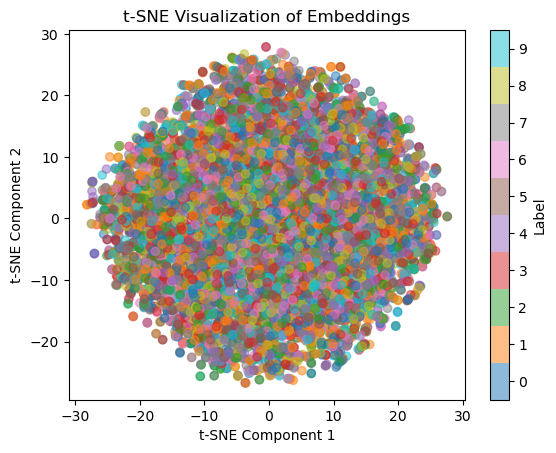

In [46]:
num_classes = len(np.unique(labels))
# Define a colormap with discrete colors
cmap = plt.colormaps["tab10"]

# Create the scatter plot
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.5
)

# Create a colorbar with discrete boundaries
bounds = np.arange(-0.5, len(np.unique(labels)) + 0.5, 1)  # boundaries for each label
norm = plt.Normalize(vmin=min(labels) - 0.5, vmax=max(labels) + 0.5)
cb = plt.colorbar(
    scatter,
    spacing="proportional",
    ticks=np.arange(min(labels), max(labels) + 1),
    boundaries=bounds,
    format="%1i",
    norm=norm,
)
cb.set_label("Label")

# Set plot title and labels
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## Generate new samples by sampling randomly from a normal distribution


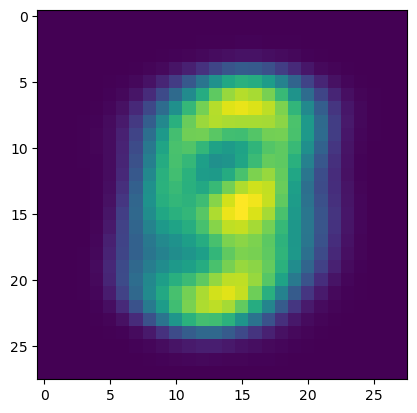

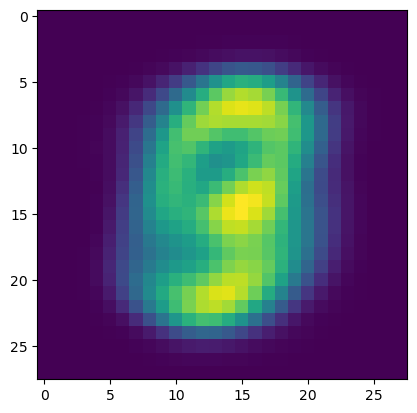

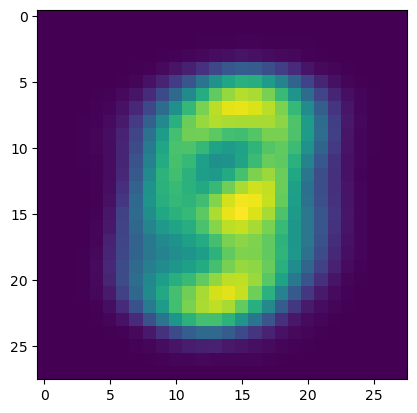

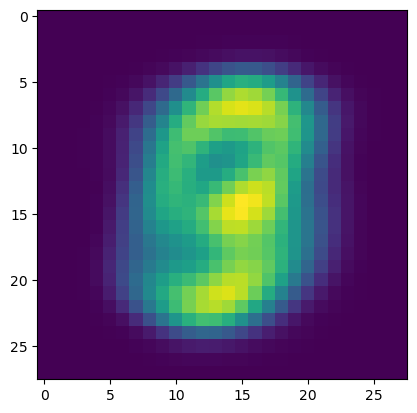

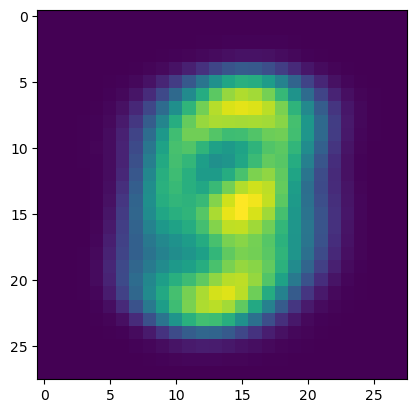

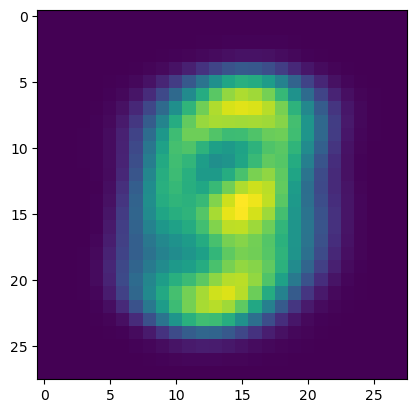

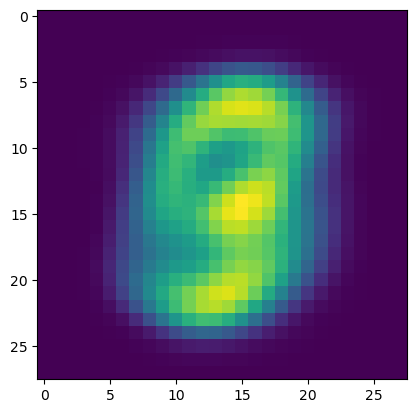

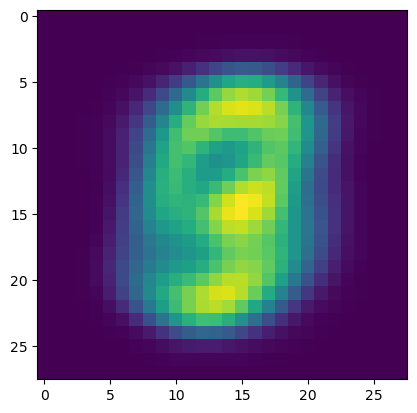

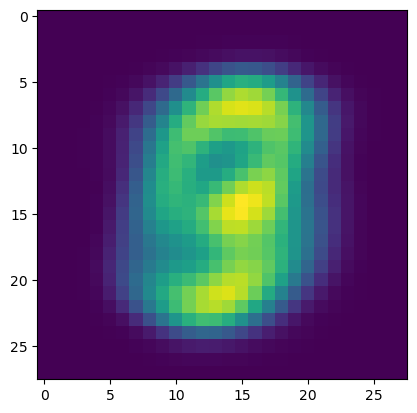

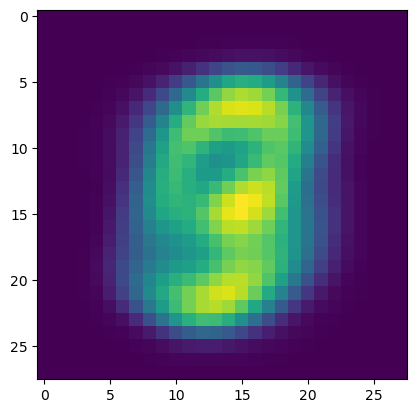

In [116]:
# batchsize, z_size
for out in model.decoder(torch.randn(10, 10)):
    plt.imshow(out.detach().squeeze(0).numpy())
    plt.show()

In [105]:
i1, l1 = train_dataset[0]
i2, l2 = train_dataset[20]
o1, *_, e1 = model(i1.unsqueeze(0))
o2, *_, e2 = model(i2.unsqueeze(0))
i1 = i1.squeeze(0)
i2 = i2.squeeze(0)
o1 = o1.detach().numpy().squeeze(0).squeeze(0)
o2 = o2.detach().numpy().squeeze(0).squeeze(0)

l1, l2

(8, 1)

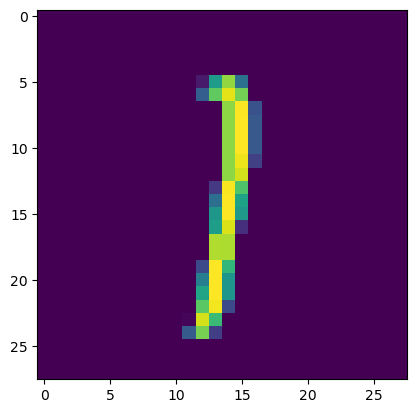

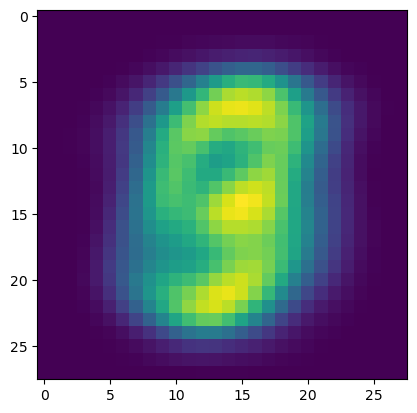

In [106]:
plt.imshow(i2)
plt.show()
plt.imshow(o2)
plt.show()

In [108]:
def interpolate(v1, v2, t):
    """
    Linearly interpolate between two vectors.

    Parameters:
        v1 (np.array): The first vector.
        v2 (np.array): The second vector.
        t (float): The interpolation factor (0 <= t <= 1).

    Returns:
        np.array: The interpolated vector.
    """
    return (1 - t) * v1 + t * v2


ts = np.linspace(0, 1, num=10)  # 10 points from 0 to 1
interpolated_embeddings = [interpolate(e1, e2, t) for t in ts]
interpolated_imgs = [
    model.decoder(e).squeeze(0).squeeze(0).detach().numpy()
    for e in interpolated_embeddings
]

In [ ]:
plt.imshow(i1.squeeze(0), cmap="gray")
plt.show()
for im in interpolated_imgs:
    plt.imshow(im, cmap="gray")
    plt.show()
plt.imshow(i2.squeeze(0), cmap="gray")

In [156]:
from torch.distributions.normal import Normal


# define a class for sampling
# this class will be used in the encoder for sampling in the latent space
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        # get the shape of the tensor for the mean and log variance
        batch, dim = z_mean.shape
        # generate a normal random tensor (epsilon) with the same shape as z_mean
        # this tensor will be used for reparameterization trick
        epsilon = Normal(0, 1).sample((batch, dim)).to(z_mean.device)
        # apply the reparameterization trick to generate the samples in the
        # latent space
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon


# define the encoder
class Encoder(nn.Module):
    def __init__(self, image_size, embedding_dim):
        super(Encoder, self).__init__()
        # define the convolutional layers for downsampling and feature
        # extraction
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        # define a flatten layer to flatten the tensor before feeding it into
        # the fully connected layer
        self.flatten = nn.Flatten()
        # define fully connected layers to transform the tensor into the desired
        # embedding dimensions
        self.fc_mean = nn.Linear(128 * 4 * 4, embedding_dim)
        self.fc_log_var = nn.Linear(128 * 4 * 4, embedding_dim)
        # initialize the sampling layer
        self.sampling = Sampling()

    def forward(self, x):
        # apply convolutional layers with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the tensor
        x = self.flatten(x)
        # get the mean and log variance of the latent space distribution
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        # sample a latent vector using the reparameterization trick
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z


class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening):
        super(Decoder, self).__init__()
        # define a fully connected layer to transform the latent vector back to
        # the shape before flattening
        self.fc = nn.Linear(
            embedding_dim,
            shape_before_flattening[0]
            * shape_before_flattening[1]
            * shape_before_flattening[2],
        )
        # define a reshape function to reshape the tensor back to its original
        # shape
        self.reshape = lambda x: x.view(-1, *shape_before_flattening)
        # define the transposed convolutional layers for the decoder to upsample
        # and generate the reconstructed image
        self.deconv1 = nn.ConvTranspose2d(
            128, 64, 3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            64, 32, 3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose2d(
            32, 1, 3, stride=2, padding=1, output_padding=1
        )

    def forward(self, x):
        # pass the latent vector through the fully connected layer
        x = self.fc(x)
        # reshape the tensor
        x = self.reshape(x)
        # apply transposed convolutional layers with relu activation function
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        # apply the final transposed convolutional layer with a sigmoid
        # activation to generate the final output
        x = torch.sigmoid(self.deconv3(x))
        return x


class VAE(L.LightningModule):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        # initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # pass the input through the encoder to get the latent vector
        z_mean, z_log_var, z = self.encoder(x)
        # pass the latent vector through the decoder to get the reconstructed
        # image
        reconstruction = self.decoder(z)
        # return the mean, log variance and the reconstructed image
        return reconstruction, z_mean, z_log_var, z

    def loss(self, x, mu, logvar, recon_x):
        recon_loss = nn.BCELoss()(x, recon_x)
        kld_loss = (
            -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        ).mean()
        return 500 * recon_loss + kld_loss

    def training_step(self, batch):
        x, _ = batch
        out, mu, logvar, _ = self(x)
        loss = self.loss(x, mu, logvar, out)
        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, _ = batch
        out, mu, logvar, _ = self(x)
        loss = self.loss(x, mu, logvar, out)
        self.log("Loss/val", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


encoder = Encoder(32, 2)
decoder = Decoder(2, (128, 4, 4))
vae = VAE(encoder, decoder)
# model(sample_batch)[0].shape
# logger = TensorBoardLogger("tb_logs", name="autoencoder")
# trainer = L.Trainer(max_epochs=10, log_every_n_steps=10)
# trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
best_val_loss = float("inf")
optimizer = vae.configure_optimizers()
# start training by looping over the number of epochs
for epoch in trange(100):
    vae.train()
    running_loss = 0.0
    # loop over the batches of the training dataset
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        # forward pass through the VAE
        recon, mu, logvar, latent = vae(data)
        # compute the VAE loss
        loss = vae.loss(data, mu, logvar, recon)
        # backward pass and optimizer step
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # compute average loss for the epoch
        train_loss = running_loss / len(train_loader)
        # compute validation loss for the epoch
        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                recon, mu, log_var, _ = vae(data)

                # sum up batch loss
                val_loss += vae.loss(data, mu, log_var, recon).item()

        val_loss /= len(test_loader.dataset)
        # print training and validation loss at every 20 epochs
        if epoch % 20 == 0 or (epoch + 1) == config.EPOCHS:
            print(
                f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
            )

        # adjust learning rate based on the validation loss
        optimizer.step(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: all elements of target should be between 0 and 1